In [1]:
from pathlib import Path
import pandas as pd
from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df, load_logs, process_logs

def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
    logs = []
    for p in paths:
        fn = Path(p) / "trajectory.parquet"
        if not fn.is_file():
            fn = Path(p) / "logs.parquet"
        logs.append(pd.read_parquet(fn))

    df = pd.concat(logs).reset_index(drop=True)
    df_cfg = pd.concat([pd.read_parquet(Path(p) / "logs_cfg.parquet") for p in paths]).reset_index(drop=True)
    df["set"] = set_id
    return df, df_cfg

scenario = "blackbox"
set_id = "full"
subset_size = 30
paths = ["../runs/SMAC3-BlackBoxFacade", "../runs/RandomSearch", "../runs/Nevergrad-CMA-ES"]

scenario = "multi-fidelity-objective"
set_id = "full"
subset_size = 9
paths = ["../runs_MOMF/SMAC3-MOMF-GP", "../runs_MOMF/RandomSearch", "../runs_MOMF/Nevergrad-DE"]

scenario = "multi-objective"
set_id = "full"
subset_size = 10
paths = ["../runs_MO/Optuna-MO", "../runs_MO/RandomSearch", "../runs_MO/Nevergrad-DE"]

scenario = "multi-fidelity"
set_id = "full"
subset_size = 20
paths = ["../runs/SMAC3-Hyperband", "../runs/SMAC3-MultiFidelityFacade", "../runs_/DEHB"]

fn = f"../data/{scenario}_{set_id}_logs.parquet"
if Path(fn).is_file():
    df = pd.read_parquet(fn)
else:
    D = []
    for rundir in paths:
        df, df_cfg = load_set([rundir], set_id="full")
        D.append(df)

    df = pd.concat(D).reset_index(drop=True)
    del D

    df = normalize_logs(df)

    normalize_performance = False
    perf_col = "trial_value__cost_inc_norm" if normalize_performance else "trial_value__cost_inc"

    df.to_parquet(f"../data/{scenario}_{set_id}_logs.parquet")

[16:50:07] INFO     Start normalization...                                                       ]8;id=629150;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=878232;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#357\357]8;;\

[16:50:08] INFO     Normalize n_trials...                                                        ]8;id=131102;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=136349;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#358\358]8;;\

[16:50:09] INFO     Normalize cost...                                                            ]8;id=433409;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=735840;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#360\360]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=955310;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=300720;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#369\369]8;;\

           INFO     Normalize time...                                                            ]8;id=709228;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=382460;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#375\375]8;;\

[16:50:10] INFO     Done.                                                                        ]8;id=257396;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=544506;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#378\378]8;;\

In [2]:
subset_size = 9
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from carps.utils.pareto_front import pareto

problem_ids = df["problem_id"].unique()
benchmark_ids = [pid.split("/")[3] for pid in problem_ids]
n_problems = len(problem_ids)

print(n_problems)

n_splits = n_problems // (subset_size * 2)
print(n_splits)
X = problem_ids
y = benchmark_ids

seeds = np.arange(0, 5)

split_classes = [StratifiedShuffleSplit, ShuffleSplit]

new_subset_performance = []
for split_class in split_classes:
    for seed in seeds:
        sss = split_class(n_splits=n_splits, test_size=0.5, random_state=seed)
        sss.get_n_splits(X, y)
        for i, (train_index, test_index) in enumerate(sss.split(X, y)):

            ids_dev = problem_ids[train_index]
            ids_test = problem_ids[test_index]
            for _set_id in ["dev", "test"]:
                new_df = df[df["problem_id"].isin(ids_dev)].copy()
                set_id = f"split_{i}_seed_{seed}_subset_{_set_id}"
                new_df["set"] = set_id
                new_subset_performance.append(new_df)

df_new = pd.concat(new_subset_performance).reset_index(drop=True)

35
1


In [ ]:
df.to_parquet(f"../data/{scenario}_{set_id}_logs.parquet")

In [3]:
# _df = pd.concat([df, df_new]).reset_index(drop=True)
_df = new_df

[16:52:32] INFO     Lost following experiments: optimizer_id                                    ]8;id=394001;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py\run_autorank.py]8;;\:]8;id=508887;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py#113\113]8;;\
                    Nevergrad-DE  RandomSearch  \                                                                  
                    problem_id                                                                                     
                    yahpo/MOMF/repl/rbv2_super/1053/repl                     NaN      0.004430                     
                    yahpo/MOMF/repl/rbv2_super/1457/repl                     NaN      0.000087                     
                    yahpo/MOMF/trainsize/iaml_super/1489/trainsize           NaN      0.001388                     
                    yahpo/MOMF/trainsize/rbv2_super/1053/trainsize           NaN      0.005711                     
                    yahpo/MOMF/trainsize/rbv2_super/1457/trainsize           NaN      0.000181                     
                                                                                                                   
                    optimizer_id                                    SMAC3-MOMF-GP                                  
                    problem_id                                                                                     
                    yahpo/MOMF/repl/rbv2_super/1053/repl                 0.103002                                  
                    yahpo/MOMF/repl/rbv2_super/1457/repl                 0.005367                                  
                    yahpo/MOMF/trainsize/iaml_super/1489/trainsize       0.001545                                  
                    yahpo/MOMF/trainsize/rbv2_super/1053/trainsize       0.006786                                  
                    yahpo/MOMF/trainsize/rbv2_super/1457/trainsize       0.000050                                  

Rejecting null hypothesis that data is normal for column Nevergrad-DE (p=0.010674<0.016667)
Rejecting null hypothesis that data is normal for column RandomSearch (p=0.001213<0.016667)
Rejecting null hypothesis that data is normal for column SMAC3-MOMF-GP (p=0.005644<0.016667)
Using Friedman test as omnibus test
Fail to reject null hypothesis that there is no difference between the distributions (p=0.124514)
               meanrank    median       mad  ci_lower  ci_upper effect_size  \
RandomSearch   1.583333  0.061162  0.061158  0.000001  0.655315         0.0   
SMAC3-MOMF-GP  2.000000  0.008662  0.008659  0.000003  0.257463     0.81074   
Nevergrad-DE   2.416667  0.133724  0.123226  0.007722  0.740391   -0.503133   

                magnitude  
RandomSearch   negligible  
SMAC3-MOMF-GP       large  
Nevergrad-DE       medium  


/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py:322: UserWarning: Result is not significant and results of the plot may be misleading!
  warnings.warn("Result is not significant and results of the plot may be misleading!")
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py:233: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by pos

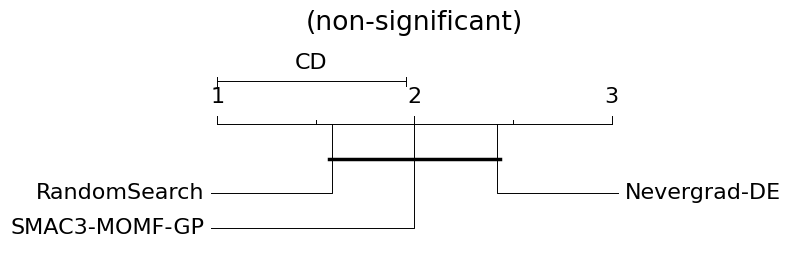

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:


In [4]:
from autorank._util import get_sorted_rank_groups, RankResult
from carps.analysis.plot_ranking import calc_critical_difference

rank_results = {}
for (scenario, set_id), gdf in _df.groupby(by=["scenario", "set"]):
    perf_col: str = "trial_value__cost_inc_norm"
    identifier = f"{scenario}_{set_id}"
    result = calc_critical_difference(gdf, identifier=identifier, figsize=(8, 3), perf_col=perf_col)
    sorted_ranks, names, groups = get_sorted_rank_groups(result, reverse=False)
    rank_results[(scenario, set_id)] = result

In [5]:
R = []
for i, (k, v) in enumerate(rank_results.items()):
    d = pd.DataFrame({
        "scenario": k[0],
        "set_id": k[1],
        **v.rankdf["meanrank"]
    }, index=[i]
    ).melt(id_vars=["scenario", "set_id"], var_name="optimizer_id", value_name="meanrank")
    d["order"] = d.rank(method="max", numeric_only=True).astype(int)
    R.append(d)
    # break

df_rank = pd.concat(R).reset_index(drop=True)
df_rank = df_rank[df_rank["set_id"] != "full"]
def rename(x: str) -> str:
    if x in ["dev", "test"]:
        return f"discrepancy_{x}"
    return x
df_rank["set_id"] = df_rank["set_id"].apply(rename)
df_rank

,scenario,set_id,optimizer_id,meanrank,order
0,multi-fidelity-objective,split_0_seed_4_subset_test,RandomSearch,1.583333,1
1,multi-fidelity-objective,split_0_seed_4_subset_test,SMAC3-MOMF-GP,2.000000,2
2,multi-fidelity-objective,split_0_seed_4_subset_test,Nevergrad-DE,2.416667,3


In [6]:

original_optimizers = {
    "blackbox": ["RandomSearch", "SMAC3-BlackBoxFacade", "Nevergrad-CMA-ES"],
    "multi-objective": ["RandomSearch", "Optuna-MO", "Nevergrad-DE"],
    "multi-fidelity": ["SMAC3-Hyperband", "SMAC3-MultiFidelityFacade", "DEHB"],
    "multi-fidelity-objective": ["RandomSearch", "SMAC3-MOMF-GP", "Nevergrad-DE"],
}


is_different = {}
for scenario, gdf in df_rank.groupby(by="scenario"):
    set_origins = gdf["set_id"].apply(lambda x: "_".join(x.split("_")[:-2])).unique()   
    for set_origin in set_origins:
        origs = original_optimizers[scenario]
        df_dev = gdf[gdf["set_id"] == f"{set_origin}_subset_dev"]
        df_test = gdf[gdf["set_id"] == f"{set_origin}_subset_test"]
        order_dev = []
        order_test = []
        for orig in origs:
            order_dev.append(df_dev[df_dev["optimizer_id"] == orig]["order"].values[0])
            order_test.append(df_test[df_test["optimizer_id"] == orig]["order"].values[0])
        _is_different = order_dev != order_test
        is_different[(scenario, set_origin)] = _is_different
is_different

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import pandas as pd
import numpy as np



fn_template = "ranks_per_set_{scenario}.csv"

decimal_places = 2

final_str = r"""
\begin{{table}}[h]
    \caption{{{caption}}}
    \label{{{label}}}
    \centering
    %\resizebox{{0.4\textwidth}}{{!}}{{
    {table_string}
    %}}
\end{{table}}
"""

float_format = lambda x: ("{:0." + str(decimal_places) + "f}").format(x) if not np.isnan(x) else "-"


for scenario, gdf in df_rank.groupby("scenario"):
    fn = fn_template.format(scenario=scenario)
    sorter = gdf[gdf["set_id"]=="dev"].sort_values("meanrank")["optimizer_id"].to_list()

    R = gdf.pivot_table(index="set_id", columns="optimizer_id", values="order").map(int)
    origs = original_optimizers[scenario]
    origs.sort(key=lambda x: sorter.index(x))
    cols = origs + [c for c in R.columns if c not in original_optimizers[scenario]]
    R = R[cols]


    MR = gdf.pivot_table(index="set_id", columns="optimizer_id", values="meanrank").map(lambda x: f"{x:.2f}" if not isinstance(x, str) else x)
    MR = MR[cols]
    for i, ((idx, row), (idx2, row2)) in enumerate(zip(MR.iterrows(), R.iterrows())):
        for j in range(len(row)):
            row.iloc[j] = row.iloc[j] + f" ({int(row2.iloc[j])})"

    print(MR)
    # table_str = MR.to_latex(float_format=float_format, na_rep="-").strip()
    # caption = f"Mean Ranking for Scenario {scenario}"
    # label = f"tab:ranking_validation_{scenario}"
    # table_str = final_str.format(table_string=table_str, label=label, caption=caption)
    # table_str = table_str.replace("_", "\_")

    # with open(fn + ".tex", "w") as file:
    #     file.write(table_str)
    # print(table_str)

: 

In [ ]:
# from pathlib import Path
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
# from carps.utils.pareto_front import pareto

# def read_set(fn: Path) -> pd.DataFrame:
#     df = pd.read_csv(fn)
#     df["problem_id"] = df["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
#     df["benchmark_id"] = df["problem_id"].apply(lambda x: x.split("/")[0])
#     df = df.melt(id_vars=["problem_id", "benchmark_id"], value_vars=p_cols, var_name="optimizer_id", value_name="performance")    
#     return df

# performance_fn = Path("/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/BB/default/df_crit.csv")
# performance = pd.read_csv(performance_fn)
# performance["problem_id"] = performance["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
# problem_ids = list(performance["problem_id"])
# n_problems = len(problem_ids)
# subset_size = 30

# rankings = []

# performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
# p_cols = [c for c in performance.columns if c not in ["problem_id", "benchmark_id"]]
# performance = performance.melt(id_vars=["problem_id", "benchmark_id"], value_vars=p_cols, var_name="optimizer_id", value_name="performance")


# path_subset_dev = performance_fn.parent / f"subset_{subset_size}.csv"
# subset_dev = read_set(path_subset_dev)

# path_subset_test = performance_fn.parent / f"subset_complement_subset_{subset_size}.csv"
# subset_test = read_set(path_subset_test)

# problem_ids_dev = subset_dev["problem_id"].to_list()
# problem_ids_test = subset_test["problem_id"].to_list()

# seeds = np.arange(0, 10)
# performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
# benchmark_ids = list(performance["benchmark_id"].unique())


# def add_rank(df: pd.DataFrame) -> pd.DataFrame:
#     D = []
#     for problem_id, gdf in df.groupby(["problem_id"]):
#         pivot = gdf.pivot(index=["problem_id", "benchmark_id"], columns="optimizer_id", values="performance").reset_index()
#         if not all([p in pivot.columns for p in p_cols]):
#             print(gdf.columns)
#             continue
#         rank = pivot[p_cols].rank(axis=1).melt(value_vars=p_cols, var_name="optimizer_id", value_name="rank")
#         gdf = pd.merge(gdf, rank, on=["optimizer_id"])
#         D.append(gdf)
#     D = pd.concat(D).reset_index(drop=True)
#     return D

# def get_ranking(df: pd.DataFrame, set_id: str, split: int = -1, seed: int = -1) -> pd.DataFrame:
#     df = add_rank(df)
#     df["set"] = set_id
#     df["split"] = split
#     df["seed"] = seed
#     return df


# rankings = []

# aggregate_func = np.mean

# mean_ranking_full = get_ranking(performance, "full")
# rankings.append(mean_ranking_full)

# mean_ranking_dev = get_ranking(subset_dev, "discrepancy_dev")
# rankings.append(mean_ranking_dev)

# mean_ranking_test = get_ranking(subset_test, "discrepancy_test")
# rankings.append(mean_ranking_test)  

# n_splits = n_problems // (subset_size * 2)
# print(n_splits)
# X = performance.values
# y = performance["benchmark_id"].to_numpy()

# split_classes = [StratifiedShuffleSplit, ShuffleSplit]

# # for split_class in split_classes:
# #     for seed in seeds:
# #         sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
# #         sss.get_n_splits(X, y)
# #         for i, (train_index, test_index) in enumerate(sss.split(X, y)):
# #             D_dev = performance.iloc[train_index]
# #             D_dev = get_ranking(D_dev, f"{split_class.__name__}_dev", i, seed)
# #             rankings.append(D_dev)

# #             D_test = performance.iloc[test_index]
# #             D_test = get_ranking(D_dev, f"{split_class.__name__}_dev", i, seed)
# #             rankings.append(D_test)


# df_ranking = pd.concat(rankings).reset_index(drop=True)

: 

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set_style("whitegrid")
# sns.set_palette("colorblind")

# gdf = df_ranking
# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(111)
# ax = sns.violinplot(data=gdf, x="optimizer_id", y="rank", hue="set", cut=0, ax=ax)
# # ax.set_title(f"use_mean: {gid}")
# plt.show()

: 

In [ ]:
# gdf = df_ranking
# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(111)
# ax = sns.histplot(data=gdf, x="performance", hue="optimizer_id", ax=ax,  element="step")
# ax = fig.add_subplot(211)
# ax = sns.histplot(data=gdf, x="rank", hue="optimizer_id", ax=ax,  element="step")
# # ax.set_title(f"use_mean: {gid}")
# plt.show()

: 

In [ ]:
# def distance_bhattacharaya(p, q):
#     return -np.log(np.sum(np.sqrt(p*q)))

# def distance_kullback_leibler(p, q):
#     return np.sum(p * np.log(p / q))

# # Performance
# distances = {}
# bin_edges = None
# for gid, gdf in df_ranking.groupby(["optimizer_id", "set"]):
#     values = gdf["performance"].values
#     q = np.histogram(values, bins=20, range=[0,1], density=True)
#     bin_edges = q[1]
#     distances[gid] = q[0]

# distributions = pd.DataFrame(distances).T
# distributions.index.name = ("optimizer_id", "set")
# distributions = distributions.reset_index(names=["optimizer_id", "set"])
# # print(distributions.columns)

# dist = {}
# for gid, gdf in distributions.groupby(by=["optimizer_id", "set"]):
#     for gid2, gdf2 in distributions.groupby(by=["optimizer_id", "set"]):
#         if gid[0] != gid2[0]:
#             continue
#         p = gdf.iloc[0].values[2:].astype(float)
#         q = gdf2.iloc[0].values[2:].astype(float)
#         d = distance_bhattacharaya(p, q)
#         # print(f"{gid} vs {gid2}: {d}")
#         dist[(gid, gid2)] = d

# heatmaps = {}
# n_sets = distributions["set"].nunique()
# sets = distributions["set"].unique()
# for ((opt, set_id), (opt, set_id2)), distance in dist.items():
#     # print(f"{opt} {set_id} vs {set_id2}: {distance}") 
#     if not opt in heatmaps:
#         heatmaps[opt] = np.zeros((n_sets, n_sets))
#     heatmaps[opt][np.where(sets == set_id)[0][0], np.where(sets == set_id2)[0][0]] = distance

# fig = plt.figure(figsize=(12, 4))
# axes = fig.subplots(1, len(heatmaps), sharex=True, sharey=True)
# for i, (opt, heatmap) in enumerate(heatmaps.items()):
#     ax = axes[i]
#     sns.heatmap(heatmap, ax=ax, xticklabels=sets, yticklabels=sets)
#     ax.set_title(opt)
# plt.show()

: 

In [ ]:


 
# for use_mean in [False]:
#     aggregate_func = lambda x: x
#     if use_mean:
#         aggregate_func = np.mean

    

#     mean_ranking_full = performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_full = performance[p_cols]
#     mean_ranking_full["problem_id"] = performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_full["set"] = "full"
#     mean_ranking_full["split"] = -1
#     mean_ranking_full["seed"] = -1
#     mean_ranking_full["use_mean"] = use_mean
#     mean_ranking_full = melt(mean_ranking_full)
#     mean_ranking_full = add_performance(mean_ranking_full)
    

#     mean_ranking_dev = subset_dev[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_dev["problem_id"] = subset_dev["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_dev["set"] = "discrepancy_dev"
#     mean_ranking_dev["split"] = -1
#     mean_ranking_dev["seed"] = -1
#     mean_ranking_dev["use_mean"] = use_mean
#     mean_ranking_dev = melt(mean_ranking_dev)
#     mean_ranking_dev = add_performance(mean_ranking_dev)

#     mean_ranking_test = subset_test[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_test["problem_id"] = subset_test["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_test["set"] = "discrepancy_test"
#     mean_ranking_test["split"] = -1
#     mean_ranking_test["seed"] = -1
#     mean_ranking_test["use_mean"] = use_mean
#     mean_ranking_test = melt(mean_ranking_test)
#     mean_ranking_test = add_performance(mean_ranking_test)

#     # easiest
#     costs = performance[p_cols].values
#     ids = pareto(-costs)
#     pareto_performance = performance.iloc[ids]
#     mean_ranking_pareto_easiest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_pareto_easiest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_pareto_easiest["set"] = "pareto_full_easiest"
#     mean_ranking_pareto_easiest["split"] = -1
#     mean_ranking_pareto_easiest["seed"] = -1
#     mean_ranking_pareto_easiest["use_mean"] = use_mean
#     mean_ranking_pareto_easiest = melt(mean_ranking_pareto_easiest)
#     mean_ranking_pareto_easiest = add_performance(mean_ranking_pareto_easiest)

#     # hardest
#     costs = performance[p_cols].values
#     ids = pareto(costs)
#     pareto_performance = performance.iloc[ids]
#     mean_ranking_pareto_hardest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
#     mean_ranking_pareto_hardest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
#     mean_ranking_pareto_hardest["set"] = "pareto_full_hardest"
#     mean_ranking_pareto_hardest["split"] = -1
#     mean_ranking_pareto_hardest["seed"] = -1
#     mean_ranking_pareto_hardest["use_mean"] = use_mean
#     mean_ranking_pareto_hardest = melt(mean_ranking_pareto_hardest)
#     mean_ranking_pareto_hardest = add_performance(mean_ranking_pareto_hardest)



#     ranking = []
#     ranking.append(mean_ranking_full)
#     ranking.append(mean_ranking_dev)
#     ranking.append(mean_ranking_test)
#     ranking.append(mean_ranking_pareto_easiest)
#     ranking.append(mean_ranking_pareto_hardest)

#     n_splits = n_problems // (subset_size * 2)
#     print(n_splits)
#     X = performance.values
#     y = performance["benchmark_id"].to_numpy()

#     split_classes = [StratifiedShuffleSplit, ShuffleSplit]

#     for split_class in split_classes:
#         for seed in seeds:
#             sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
#             sss.get_n_splits(X, y)
#             for i, (train_index, test_index) in enumerate(sss.split(X, y)):
#                 D_dev = performance.iloc[train_index][p_cols].rank(axis=1).apply(aggregate_func)
#                 D_dev["problem_id"] = performance.iloc[train_index]["problem_id"] if not use_mean else "mean_problem"
#                 D_dev["set"] = f"{split_class.__name__}_dev"
#                 D_dev["split"] = i
#                 D_dev["seed"] = seed
#                 D_dev["use_mean"] = use_mean
#                 D_dev = melt(D_dev)
#                 D_dev = add_performance(D_dev)
                
#                 D_test = performance.iloc[test_index][p_cols].rank(axis=1).apply(aggregate_func)
#                 D_test["problem_id"] = performance.iloc[test_index]["problem_id"] if not use_mean else "mean_problem"
#                 D_test["set"] = f"{split_class.__name__}_test"
#                 D_test["split"] = i
#                 D_test["seed"] = seed
#                 D_test["use_mean"] = use_mean
#                 D_test = melt(D_test)
#                 D_test = add_performance(D_test)
#                 ranking.extend([D_dev, D_test])

#     df_ranking = pd.DataFrame(ranking) if use_mean else pd.concat(ranking).reset_index(drop=True)
#     df_ranking = df_ranking.melt(id_vars=["set", "split", "seed", "problem_id", "use_mean"], value_vars=p_cols, var_name="optimizer_id", value_name="rank")
#     rankings.append(df_ranking)

# df_ranking = pd.concat(rankings).reset_index(drop=True)
# df_ranking


: 